# Residual Neural Networks: for Cifar-10 classification

### Author: Andrea Murphy

#### Description: An example of an advanced feedforward neural network architecture 

In [0]:
from __future__ import print_function
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import Input, Flatten, Dropout
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers.merge import Add
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import os
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)
K.tensorflow_backend.set_session(get_session())


import sys
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Load the data from the Cifar-10 dataset

https://www.cs.toronto.edu/~kriz/cifar.html 

In [0]:
(xtr, ytr), (xte, yte) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


### View random images in the dataset

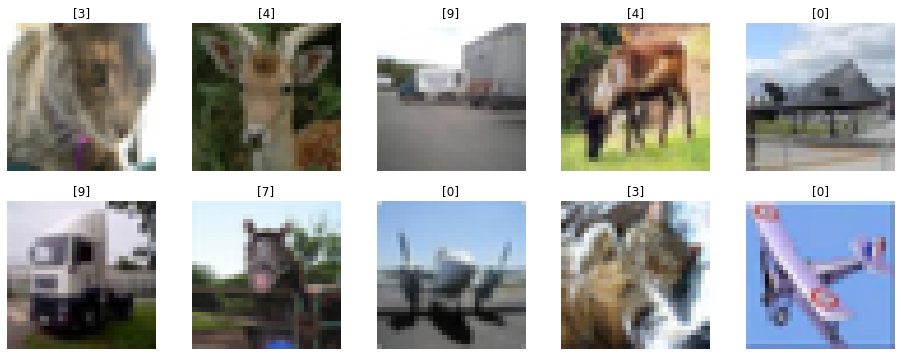

In [0]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6))

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(xtr), 1)[0]
        ax[i, j].imshow(xtr[idx, :, :])
        ax[i, j].axis('off')
        ax[i, j].set_title(ytr[idx])

In [0]:
def conv_block(output_depth, prev_layer):
    """
    Expects no activation function on prev_layer
    """
    x = BatchNormalization()(prev_layer)
    x = Activation('relu')(prev_layer)
    x = Conv2D(output_depth, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = Conv2D(output_depth, 3, strides=(2, 2), padding='same', kernel_initializer='he_normal')(x)
    return x


def skip_block(input_depth, output_depth, prev_layer):
    if input_depth == output_depth:
        return prev_layer
    else:
        x = Conv2D(output_depth, 1, strides=(2, 2), padding='same', kernel_initializer='he_normal')(prev_layer)
        return x
        

def residual_block(input_depth, output_depth, prev_layer):
    conv = conv_block(output_depth, prev_layer)
    skip = skip_block(input_depth, output_depth, prev_layer)
    add = Add()([conv, skip])
    return add

In [0]:
inputs = Input((32, 32, 3))
conv1 = Conv2D(16, 3, padding='same', kernel_initializer='he_normal')(inputs)
res1 = residual_block(16, 32, conv1)
res2 = residual_block(32, 64, res1)
res3 = residual_block(64, 128, res2)
b1 = BatchNormalization()(res3)
a1 = Activation('relu')(b1)
gap = GlobalAveragePooling2D()(a1)
out = Dense(10, activation='softmax')(gap)

model = Model(inputs=inputs, outputs=out)

optim = Adam(lr=0.001)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        activation_1[0][0]               
____________________________________________________________________________________________

### Normalize the data 

In [0]:
xtr = xtr.astype('float32') / 255
xte = xte.astype('float32') / 255

### Subtracting pixel mean to improve the accuracy

In [0]:
subtract_pixel_mean = True

if subtract_pixel_mean:
    xtr_mean = np.mean(xtr, axis=0)
    xtr -= xtr_mean
    xte -= xtr_mean

In [0]:
print('xtr shape:', xtr.shape)
print(xtr.shape[0], 'Training Samples')
print(xte.shape[0], 'Testing Samples')
print('ytr shape:', ytr.shape)

xtr shape: (50000, 32, 32, 3)
50000 Training Samples
10000 Testing Samples
ytr shape: (50000, 1)


### Convert class vectors to binary class matrices

In [0]:
import keras

ytr = keras.utils.to_categorical(ytr)
yte = keras.utils.to_categorical(yte)

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

hist = model.fit(xtr, ytr, epochs=55, batch_size=128, validation_split=0.2, 
                 callbacks=[early_stop, reduce_lr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 10000 samples
Epoch 1/55
40000/40000 [==============================] - 13s 337us/step - loss: 1.5770 - acc: 0.4240 - val_loss: 1.6537 - val_acc: 0.4149
Epoch 2/55
40000/40000 [==============================] - 6s 148us/step - loss: 1.2009 - acc: 0.5685 - val_loss: 1.2891 - val_acc: 0.5428
Epoch 3/55
40000/40000 [==============================] - 6s 148us/step - loss: 1.0194 - acc: 0.6357 - val_loss: 1.1161 - val_acc: 0.6081
Epoch 4/55
40000/40000 [==============================] - 6s 148us/step - loss: 0.9199 - acc: 0.6748 - val_loss: 0.9303 - val_acc: 0.6724
Epoch 5/55
40000/40000 [==============================] - 6s 148us/step - loss: 0.8463 - acc: 0.6993 - val_loss: 0.9332 - val_acc: 0.6654
Epoch 6/55
40000/40000 [==============================] - 6s 148us/step - loss: 0.7922 - acc: 0.7195 - val_loss: 0.8897 - val_acc: 0.6907
Epoch 7/55
40000/40000 [=

In [0]:
model.evaluate(xte, yte)

10000/10000 [==============================] - 1s 92us/step


[0.5212983164787293, 0.8278]